## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/fold_1.tar.gz
# !tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/fold_2.tar.gz
# !tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/fold_3.tar.gz
# !tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/fold_4.tar.gz
# !tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-64-clean-split/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training set samples: {len(k_fold)}')
display(k_fold.head())

Training set samples: 27375


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded , if i were going","i`d have responded , if i were going",neutral,1.000000,37,9,11,37,9,11,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego ! ...,sooo sad,negative,0.181818,51,16,18,8,2,3,train,train,validation,train,train,False
2,088c60f138,my boss is bullying me . . .,bullying me,negative,0.333333,31,11,11,11,2,2,validation,train,train,train,train,False
3,9642c003ef,what interview ! leave me alone,leave me alone,negative,0.500000,32,7,7,14,3,3,validation,train,train,train,train,False
4,358bd9e861,"sons of * * * * , why couldn`t they put ...","sons of * * * * ,",negative,0.266667,84,24,26,23,13,13,train,train,train,train,validation,False


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 64,
  'BATCH_SIZE': 32,
  'EPOCHS': 7,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 2,
  'N_FOLDS': 1,
  'question_size': 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 1e-07 to 3e-05 to 1e-06


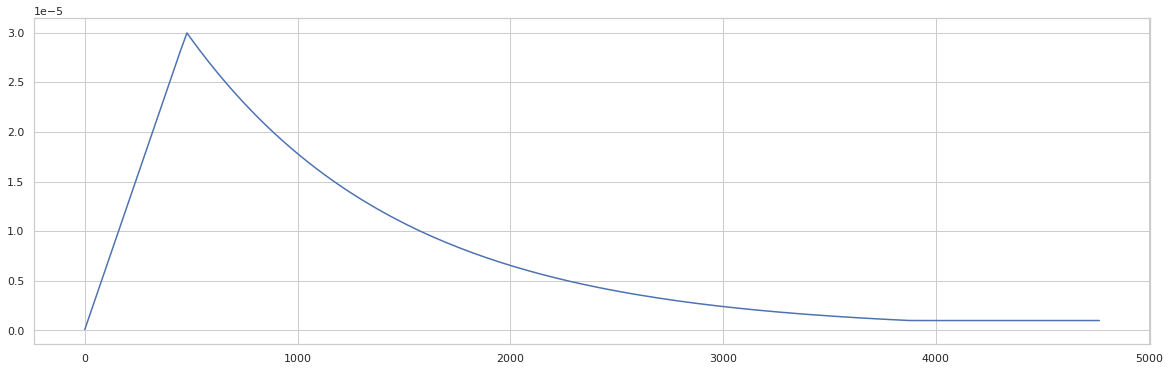

In [6]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = total_steps * 0.1
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h11 = hidden_states[-2]

    x = layers.Dropout(.1)(h11)
    
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(x)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(x)
    end_logits = layers.Flatten()(end_logits)
    

    start_probs = layers.Activation('softmax', name='y_start')(start_logits)
    end_probs = layers.Activation('softmax', name='y_end')(end_logits)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_probs, end_probs])
    
    return model

# Train

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(),
                                   'y_end': losses.CategoricalCrossentropy()})
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)

    # Make predictions
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 684 steps, validate for 171 steps
Epoch 1/7
684/684 - 179s - loss: 2.8319 - y_start_loss: 1.3794 - y_end_loss: 1.4525 - val_loss: 1.7144 - val_y_start_loss: 0.8451 - val_y_end_loss: 0.8693
Epoch 2/7
684/684 - 166s - loss: 1.6750 - y_start_loss: 0.8416 - y_end_loss: 0.8334 - val_loss: 1.6331 - val_y_start_loss: 0.8109 - val_y_end_loss: 0.8222
Epoch 3/7
684/684 - 165s - loss: 1.4965 - y_start_loss: 0.7596 - y_end_loss: 0.7369 - val_loss: 1.6490 - val_y_start_loss: 0.8173 - val_y_end_loss: 0.8317
Epoch 4/7
Restoring model weights from the end of the best epoch.
684/684 - 165s - loss: 1.3778 - y_start_loss: 0.7035 - y_end_loss: 0.6744 - val_loss: 1.6859 - val_y_start_loss: 0.8361 - val_y_end_loss: 0.8498
Epoch 00004: early stopping


# Model loss graph

Fold: 1


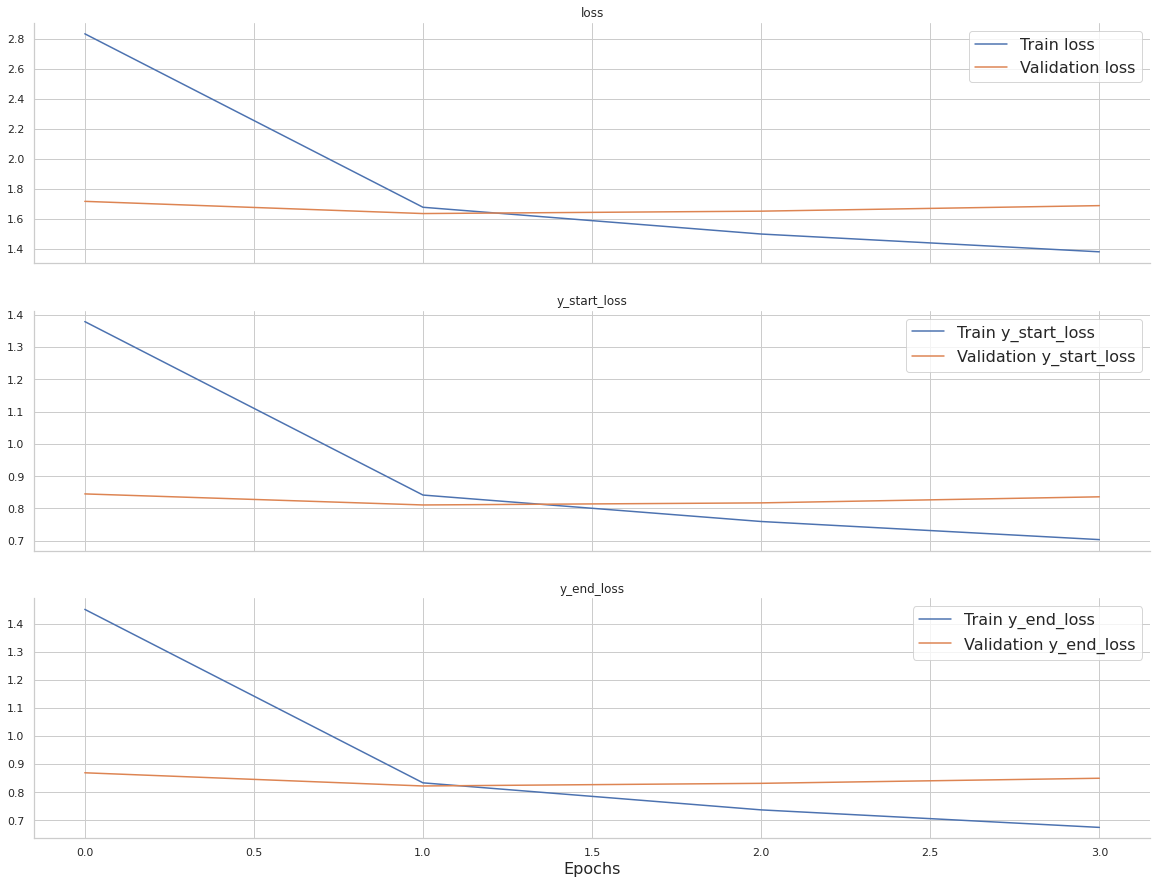

In [9]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric/Jaccard,,,,,
Overall,0.756152,0.723301,0.032851,0.756152,0.723301
Sentiment negative,0.615861,0.564545,0.051316,0.615861,0.564545
Sentiment neutral,0.974040,0.975000,-0.000960,0.974040,0.975000
Sentiment positive,0.599663,0.539403,0.060261,0.599663,0.539403
0 <= text tokens < 3,0.952128,0.930000,0.022128,0.952128,0.930000
3 <= text tokens < 15,0.822780,0.800507,0.022273,0.822780,0.800507
15 <= text tokens < 30,0.741575,0.702194,0.039382,0.741575,0.702194
30 <= text tokens < 45,0.697337,0.663982,0.033355,0.697337,0.663982
45 <= text tokens < 120,0.684357,0.646122,0.038234,0.684357,0.646122


# Visualize predictions

In [11]:
k_fold['jaccard_mean'] = 0

for n in range(config['N_FOLDS']):
    k_fold['jaccard_mean'] += k_fold[f'jaccard_fold_{n+1}'] / config['N_FOLDS']

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean'] + [c for c in k_fold.columns if (c.startswith('prediction_fold'))]].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean,prediction_fold_1
0,"i`d have responded , if i were going","i`d have responded , if i were going",neutral,11,11,1.000000,1.000000,"i`d have responded , if i were going"
1,sooo sad i will miss you here in san diego ! ...,sooo sad,negative,18,3,0.181818,0.500000,sad
2,my boss is bullying me . . .,bullying me,negative,11,2,0.333333,0.666667,bullying me . . .
3,what interview ! leave me alone,leave me alone,negative,7,3,0.500000,1.000000,leave me alone
4,"sons of * * * * , why couldn`t they put ...","sons of * * * * ,",negative,26,13,0.266667,1.000000,"sons of * * * * ,"
5,http : / / www . dothebouncy . com / smf - ...,http : / / www . dothebouncy . com / smf - ...,neutral,33,33,1.000000,1.000000,http : / / www . dothebouncy . com / smf - ...
6,2am feedings for the baby are fun when he is a...,fun,positive,17,1,0.071429,1.000000,fun
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000,soooo high
8,both of you,both of you,neutral,3,3,1.000000,1.000000,both of you
9,journey ! ? wow . . . u just became coole...,wow . . . u just became cooler .,positive,38,13,0.400000,1.000000,wow . . . u just became cooler .
